## Hierarchical Clustering for seeding (Max May)
In the NCAA March Madness tournament there are 64 teams each year qualified 
to participate. These 64 Teams are grouped by a comitee into 16 seeds. 
Each seed consists 4 teams which have approximately the same performance. 
With seed number 1 containing the four best teams to seed number 16 containing 
the 4 weakest teams.

The task is to cluster the teams from the tournament based on their season stats 
and then compare the clustering to the decision from the comitee.
Hierarchical clustering is used to build a grouping with variable cluster sizes 
depending on where the tree is cut. As the distincion between 16 seeds might be too
hard, an even number of seeds can be conflated to one and the clustering validation
can be compared for different seed sizes.

In [57]:
import os
import numpy as np
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import cluster
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

First, the data of the tournament from 2010-2018 is retrieved from a csv file and
organized as a pandas dataframe. There is one function for getting all teams from each
year participating in the tournament with their stats and respective seed in the
corresponding year.
And another function which loads all data, distinguishing only between qualified and
non-qualified teams.

In [30]:
def get_team_data(filter_year=None,datasets_dir=None,stats_file_name=None):
    datasets_dir = '../datasets'
    stats_file_name = 'Stats by team and year 2010-2018.csv'
    stats_file_path = os.path.join(datasets_dir, stats_file_name) 
    df_stats = pd.read_csv(stats_file_path, sep=',')
    df_stats = df_stats.loc[:, ~df_stats.columns.str.contains('^Unnamed')]
    df_stats = df_stats.loc[:, df_stats.columns.str.contains('Norm$|Year|Seed')]
    if filter_year != None:
        df_stats = df_stats.loc[df_stats['Year'] == filter_year,:]
    df_stats = df_stats.loc[df_stats['Seed'] != 0,:]
    df_stats = df_stats.drop(['Year','Seed Norm'],axis=1)
    df_stats.reset_index(drop=True,inplace=True)
    label = df_stats['Seed']       
    data = df_stats.loc[:, ~df_stats.columns.str.contains('Seed')]
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)
    return data, label

def adjustNumberOfSeeds(label_true,Nseeds):
    label_adj = pd.Series.copy(label_true)
    if Nseeds < 16:
        n_perSeed = round(16/Nseeds)
        for n in range(0,Nseeds):
            label_adj.loc[((label_true>n*n_perSeed) & (label_true<=(n+1)*n_perSeed))]=n+1
    return label_adj

def get_qual_data(filter_year=None):
    datasets_dir = '../datasets'
    stats_file_name = 'Stats by team and year 2010-2018.csv'
    stats_file_path = os.path.join(datasets_dir, stats_file_name) 
    df_stats = pd.read_csv(stats_file_path, sep=',')
    df_stats = df_stats.loc[:, ~df_stats.columns.str.contains('^Unnamed')]
    df_stats = df_stats.loc[:, df_stats.columns.str.contains('Norm$|Year|Seed')]
    if filter_year != None:
        df_stats = df_stats.loc[df_stats['Year'] == filter_year,:]
    df_stats = df_stats.drop(['Year','Seed Norm'],axis=1)
    df_stats.loc[df_stats['Seed']!=0,'Seed'] = 1
    df_stats.reset_index(drop=True,inplace=True)
    label = df_stats['Seed']       
    data = df_stats.loc[:, ~df_stats.columns.str.contains('Seed')]
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)
    return data, label

In [31]:
team_stats, seeds = get_team_data(filter_year=None, datasets_dir='../datasets', stats_file_name=None)

In [32]:
seeds.value_counts()

16    36
15    36
14    36
13    36
12    36
11    36
10    36
9     36
8     36
7     36
6     36
5     36
4     36
3     36
2     36
1     36
Name: Seed, dtype: int64

In [33]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   W-L% Norm             576 non-null    float64
 1   SOS Norm              576 non-null    float64
 2   ORtg Norm             576 non-null    float64
 3   DRtg Norm             576 non-null    float64
 4   FG% Norm              576 non-null    float64
 5   WL% * SOS Norm        576 non-null    float64
 6   3P% Norm              576 non-null    float64
 7   FT% Norm              576 non-null    float64
 8   PPG Norm              576 non-null    float64
 9   OPPG Norm             576 non-null    float64
 10  APG Norm              576 non-null    float64
 11  TOVPG Norm            576 non-null    float64
 12  Adjusted WL% Norm     576 non-null    float64
 13  Adjusted Margin Norm  576 non-null    float64
dtypes: float64(14)
memory usage: 63.1 KB


/home/max/PycharmProjects/CS7641-NCAA-Predictions/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/max/PycharmProjects/CS7641-NCAA-Predictions/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/max/PycharmProjects/CS7641-NCAA-Predictions/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.sta

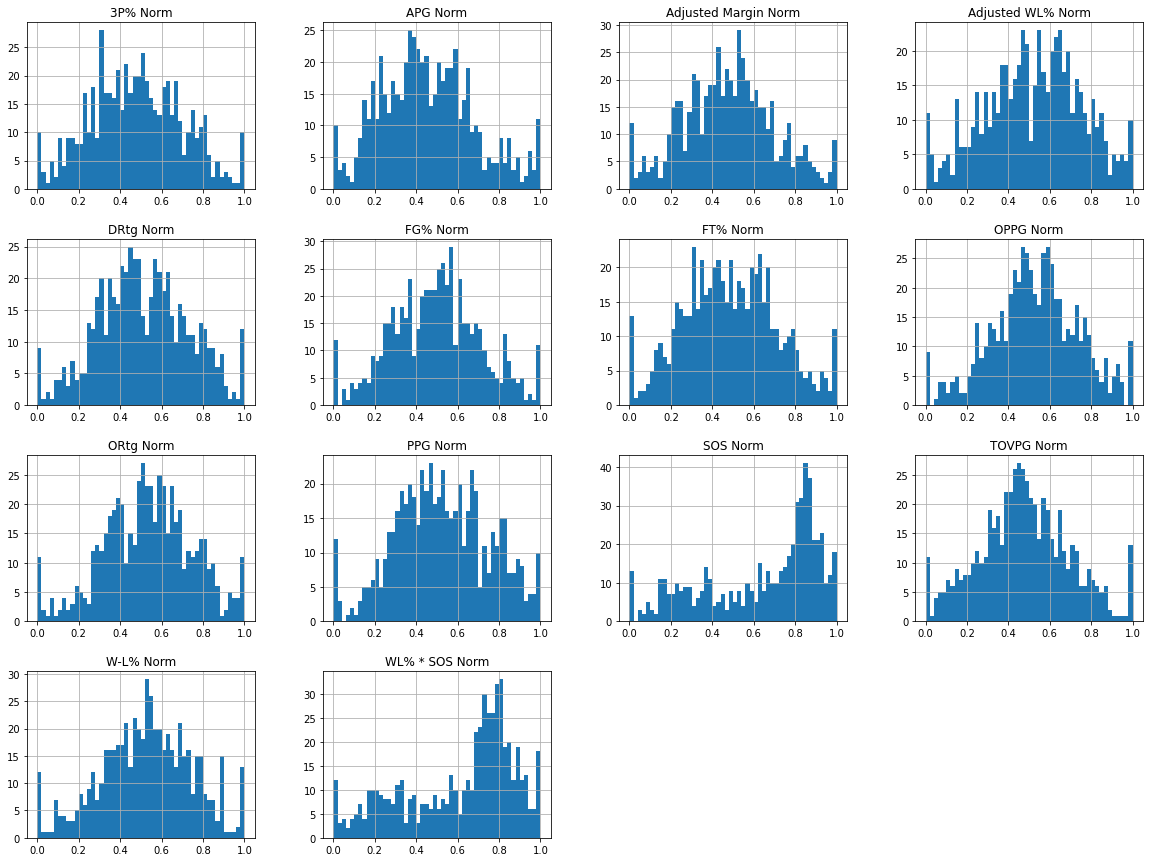

In [34]:
%matplotlib inline
team_stats.hist(bins=50, figsize=(20,15))
plt.show()

Principal component analysis is used in the preprocessing to reduce the number of features
from 14 to 9. Getting a retained variance of at least 95%.

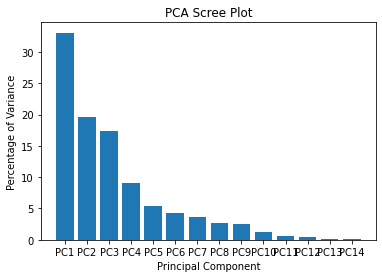

In [35]:
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(team_stats)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14'])

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14']
plt.bar(x= range(1,15), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [36]:
variance = 0
dim = 1
while variance < .95:
    variance = np.sum(pca.explained_variance_ratio_[:dim])
    dim = dim + 1
print("We need %2d features to recover %2.1f%% of the variance."%(dim,variance*100))

We need  9 features to recover 95.1% of the variance.


In [37]:
pcaTeam_stats = principalDf.drop(['PC10','PC11','PC12','PC13','PC14'],axis=1)

Through PCA the data can be visualized in 3D by the first three principal components.
If only data from a single year is selected, one can see that it is hard to group these
data points into clusters using only three features. If the data from all nine years is 
plotted, some patterns and clusters can be seen. But its still hard to disinguish
between some of the overlapping seed clusters.

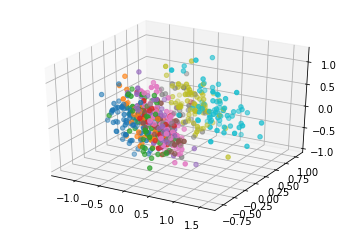

In [38]:
pca3 = PCA(n_components=3)
pC3 = pca3.fit_transform(team_stats)
pDf3 = pd.DataFrame(data = pC3
             , columns = ['pc1', 'pc2', 'pc3'])
scatter3D = plt.figure().gca(projection='3d')
scatter3D.scatter(pDf3['pc1'],pDf3['pc2'],pDf3['pc3'],c=seeds,cmap=plt.get_cmap('tab10'))

We can use a dendrogram to visualize how different choices for the distance calculation
between clusters affect the creation of the hierarchical tree. Our goal is to avoid chaining
effects and aim for evenly sized clusters. To achieve this the average linkage is a good choice.

In [39]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

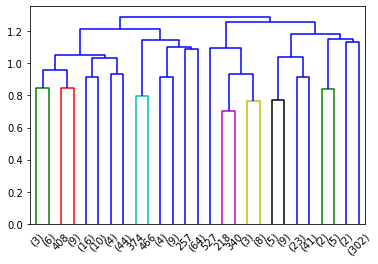

In [40]:
dCluster = cluster.AgglomerativeClustering(n_clusters=None,distance_threshold=0,affinity="euclidean",linkage='average')
hdistance_team = dCluster.fit(pcaTeam_stats)
plot_dendrogram(hdistance_team,truncate_mode='level',p=4)

For the evaluation of the cluster performance we can match the cluster numbers from the
algorithm with the seed labels from the data set, using the contigency matrix and maximum
weight matching.
Now we can calculate the purity from the matched clusters.

In [41]:
import itertools
def get_permutations(setSize):
    perm = list(itertools.permutations(range(setSize),setSize))
    return np.array(perm)

def max_weight_match(confMat):
    perm = get_permutations(np.size(confMat,axis=0))
    weightSum = np.zeros(np.size(perm,axis=0))
    for i in range(np.size(perm,axis=0)):
        weightSum[i] = np.sum(confMat[range(np.size(perm,axis=1)),perm[i,:]])
    return perm[np.argmax(weightSum),:]

def rematch_clusters(y_true,y_pred):
    conMatrix = metrics.cluster.contingency_matrix(y_true,y_pred).T
    newMatching = max_weight_match(conMatrix)
    y_newMatch = np.zeros(y_pred.shape)
    for i in range(len(newMatching)):
        y_newMatch[y_pred == i] = newMatching[i]
    return y_newMatch

def matched_purity(y_true,y_pred):
    y_pred = rematch_clusters(y_true,y_pred)
    conMatrix = metrics.cluster.contingency_matrix(y_true,y_pred).T
    match = max_weight_match(conMatrix)
    purity = np.sum(conMatrix[range(np.size(conMatrix,axis=0)),match])/np.sum(conMatrix)
    return purity

The rows of the old contingency matrix are swapped according to the matching
to get the new contingency matrix.

In [42]:
y_true = adjustNumberOfSeeds(seeds,4)
y_true = np.array(y_true)
hCluster = cluster.AgglomerativeClustering(n_clusters=4,affinity="euclidean",linkage="average")
seedCluster = hCluster.fit(pcaTeam_stats)
y_pred = seedCluster.labels_

conMatrix = metrics.cluster.contingency_matrix(y_true,y_pred).T    
conMatrix

array([[143, 134, 106,   6],
       [  0,   0,   2,  78],
       [  0,   3,   8,   3],
       [  1,   7,  28,  57]])

In [43]:
max_weight_match(conMatrix)

array([0, 3, 1, 2])

In [44]:
y_new = rematch_clusters(y_true,y_pred)
newConMat = metrics.cluster.contingency_matrix(y_true,y_new).T
newConMat

array([[143, 134, 106,   6],
       [  0,   3,   8,   3],
       [  1,   7,  28,  57],
       [  0,   0,   2,  78]])

The matched purity is a little lower as each ground truth can only be matched by one cluster.
But as the permutations increase with the factorial, computation time is significantly
increased for 8 and 16 seed matching. Therefore, we will use the more simple computation
of purity in the following code.

In [45]:
np.sum(np.amax(conMatrix,axis=1))/np.sum(conMatrix)

0.4965277777777778

In [46]:
matched_purity(y_true,y_pred)

0.4375

Now let us perform hierarchical clustering with full 16,8,4 and 2 seed partitioning of
the qualified teams in the tournament.

In [47]:
clusterSizes = [2,4,8,16]
purity = np.zeros(len(clusterSizes))
randScore = np.zeros(len(clusterSizes))
mutInfo = np.zeros(len(clusterSizes))
for i,seedNumber in enumerate(clusterSizes):
    y_true = adjustNumberOfSeeds(seeds,seedNumber)
    y_true = np.array(y_true)
    hCluster = cluster.AgglomerativeClustering(n_clusters=seedNumber
                                               ,affinity="euclidean"
                                               ,linkage="average")
    seedCluster = hCluster.fit(pcaTeam_stats)
    y_pred = seedCluster.labels_
    
    conMat = metrics.cluster.contingency_matrix(y_true,y_new).T
    #Performance measures
    purity[i] = np.sum(np.amax(conMat,axis=1))/np.sum(conMat)
    print("Clustering in %d seeds reaches a purity of %.2f."%(seedNumber,purity[i]))
    
    randScore[i] = metrics.adjusted_rand_score(y_true,y_pred)
    print("Clustering in %d seeds reaches a adjusted rand index of %.2f."%(seedNumber,randScore[i]))
    
    mutInfo[i] = metrics.adjusted_mutual_info_score(y_true,y_pred)
    print("Clustering in %d seeds reaches a adjusted mutual information of %.2f."%(seedNumber,mutInfo[i]))

Clustering in 2 seeds reaches a purity of 0.79.
Clustering in 2 seeds reaches a adjusted rand index of 0.30.
Clustering in 2 seeds reaches a adjusted mutual information of 0.32.
Clustering in 4 seeds reaches a purity of 0.50.
Clustering in 4 seeds reaches a adjusted rand index of 0.22.
Clustering in 4 seeds reaches a adjusted mutual information of 0.36.
Clustering in 8 seeds reaches a purity of 0.31.
Clustering in 8 seeds reaches a adjusted rand index of 0.16.
Clustering in 8 seeds reaches a adjusted mutual information of 0.32.
Clustering in 16 seeds reaches a purity of 0.17.
Clustering in 16 seeds reaches a adjusted rand index of 0.10.
Clustering in 16 seeds reaches a adjusted mutual information of 0.26.


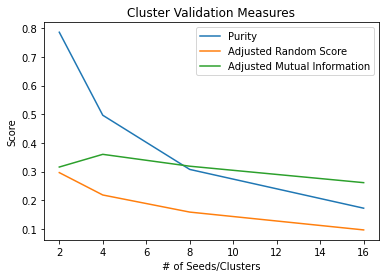

In [48]:
plt.plot(clusterSizes,purity,label='Purity')
plt.plot(clusterSizes,randScore,label='Adjusted Random Score')
plt.plot(clusterSizes,mutInfo,label='Adjusted Mutual Information')
plt.xlabel('# of Seeds/Clusters')
plt.ylabel('Score')
plt.title('Cluster Validation Measures')
plt.legend()

The purity gives us an indicator of how purely the clusters consist of only datapoints
from a single ground truth, with 1 corresponding to the best purity. 
For the given task we get the best purity when we only partition
into two seeds and the purity decreases with the number of seeds, as expected.


The mutual information measures the amount of information shared between clustering
and ground truth. The adjusted variant of MI is independent of the number of clusters in
 a partition, otherwise a higher number of clusters would give a better MI score.
 Larger values indicate a good clustering. Our results show a slight decrease in the AMI for
 a increased number of seeds.
 

The random score is a pairwise measure, which is the fraction of true positives and true 
negatives over the total number of pairs. The adjusted rand score is centered and normalized
to adjust for chance. Negative values are bad, close to zero means random and a score of one
means that the clusterings are identical up to label permutations.
For our task the ARI slightly decreases with the number of seeds.


An overall trend of decreased performance can be observed as the partitioning of the teams
into the seeds gets finer. With a purity below 20% for partitioning into the regular 16 seeds,
this means that this task is harder than expected based on the provided
features. 

In [49]:
print("Purity for 16 seeds is %.2f"%(purity[3]))

Purity for 16 seeds is 0.17


#### Qualified vs. non-qualified clustering
Another clustering task is to determine what teams got qualified for the tournament.

In [50]:
team_stats_all, qualified = get_qual_data(filter_year=None)
qualified.value_counts()

0    2549
1     576
Name: Seed, dtype: int64

The 3D visualzation via PCA shows that the clusters of qualified vs. non-qualfied teams
is much better to distinguish.

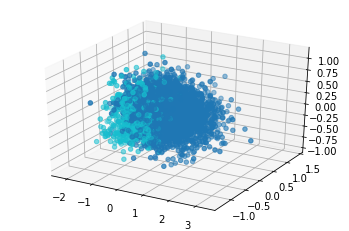

In [51]:
pca3 = PCA(n_components=3)
pC3 = pca3.fit_transform(team_stats_all)
pDf3 = pd.DataFrame(data = pC3
             , columns = ['pc1', 'pc2', 'pc3'])
scatter3D = plt.figure().gca(projection='3d')
scatter3D.scatter(pDf3['pc1'],pDf3['pc2'],pDf3['pc3'],c=qualified,cmap=plt.get_cmap('tab10'))

This is also visible in the decrease in variance of the principal components. 
Over 50% of the variance is contained in the first component, whereas the other components
only have minor contributions.

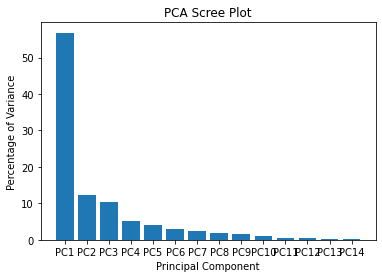

In [52]:
pcaAll = PCA(n_components=14)
principalComponents = pcaAll.fit_transform(team_stats_all)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14'])

percent_variance = np.round(pcaAll.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14']
plt.bar(x= range(1,15), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [53]:
variance = 0
dim = 1
while variance < .95:
    variance = np.sum(pcaAll.explained_variance_ratio_[:dim])
    dim = dim + 1
print("We need %2d features to recover %2.1f%% of the variance."%(dim,variance*100))

We need  9 features to recover 96.2% of the variance.


In [60]:
pcaTeam_stats_all = principalDf.drop(['PC10','PC11','PC12','PC13','PC14'],axis=1)

In [69]:
qualCluster = cluster.AgglomerativeClustering(n_clusters=2,affinity="euclidean",linkage='average')
qualTournament = qualCluster.fit(pcaTeam_stats_all)
y_true = np.array(qualified)
y_pred = qualTournament.labels_
conMatrixQ = metrics.cluster.contingency_matrix(y_true,y_pred).T
#Performance measures
purityQ = np.sum(np.amax(conMatrixQ,axis=1))/np.sum(conMatrixQ)
print("Qualifying clustering reaches a purity of %.2f."%(purityQ))

randScoreQ = metrics.adjusted_rand_score(y_true,y_pred)
print("Qualifying clustering reaches a adjusted rand index of %.2f."%(randScoreQ))

mutInfoQ = metrics.adjusted_mutual_info_score(y_true,y_pred)
print("Qualifying clustering reaches a AMI of %.2f."%(mutInfoQ))

Qualifying clustering reaches a purity of 0.82.
Qualifying clustering reaches a adjusted rand index of -0.01.
Qualifying clustering reaches a AMI of 0.01.


In [70]:
metrics.cluster.contingency_matrix(y_true,y_pred).T

array([[2521,  576],
       [  28,    0]])

We reach a purity of 82% for the qualified vs. non-qualfied clustering.
As both clusters contain mainly points from one ground truth. But from the
contigency matrix we can see that both clusters are assigned to the same ground
truth partition. This results in a bad ARI and AMI score.




